In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM


In [5]:
# Choose stock ticker
stock = "RELIANCE.NS"   # Examples: AAPL, TSLA, TCS.NS, INFY.NS

# Download stock data
df = yf.download(stock, start="2015-01-01", end="2024-12-31")

# Show first rows
df.head()

C:\Users\Neha Kumari\AppData\Local\Temp\ipykernel_9176\1631107769.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2015-01-01,189.999802,190.877155,189.090351,189.657431,2963643
2015-01-02,189.496964,191.743844,189.229486,190.042631,7331366
2015-01-05,187.421265,190.641790,187.046782,189.379255,10103941
2015-01-06,178.915237,186.811392,178.037884,186.169433,18627980
2015-01-07,182.809830,183.772776,179.107845,179.129243,20720312


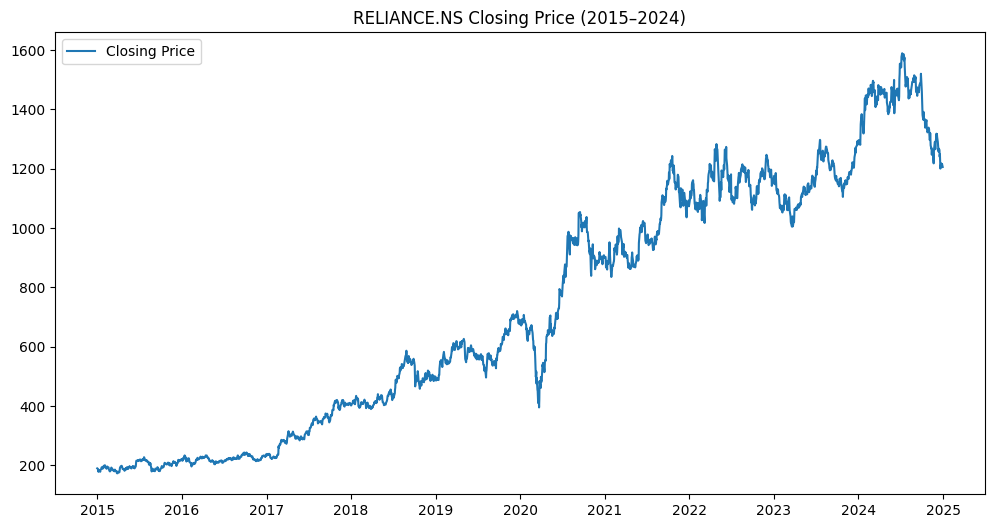

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
count,2466.000000,2466.000000,2466.000000,2466.000000,2.466000e+03
mean,730.502957,738.493599,723.151486,731.032044,1.843374e+07
std,419.824162,423.732136,416.248105,420.130881,1.355283e+07
min,173.490646,174.977862,170.430622,174.742482,1.705656e+06
25%,315.431152,317.548429,313.001629,315.694093,1.071503e+07
50%,641.974060,652.039480,636.482799,645.038396,1.464605e+07
75%,1121.059937,1133.464029,1111.866075,1122.602485,2.109906e+07
max,1589.138062,1596.980044,1573.851280,1592.662006,1.426834e+08


In [6]:
# Plot Closing Price
plt.figure(figsize=(12,6))
plt.plot(df["Close"], label="Closing Price")
plt.title(f"{stock} Closing Price (2015–2024)")
plt.legend()
plt.show()

# Summary statistics
df.describe()

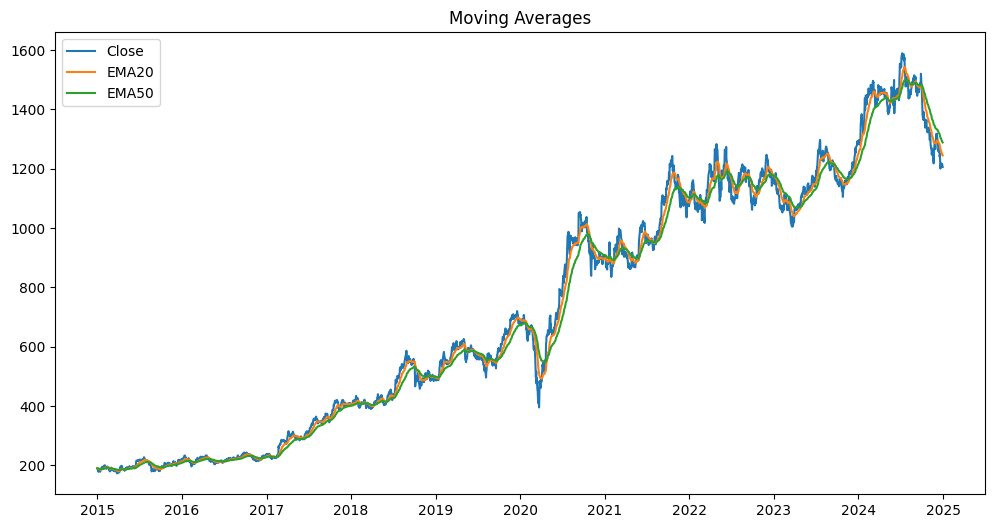

In [7]:
df["EMA20"] = df["Close"].ewm(span=20, adjust=False).mean()
df["EMA50"] = df["Close"].ewm(span=50, adjust=False).mean()

plt.figure(figsize=(12,6))
plt.plot(df["Close"], label="Close")
plt.plot(df["EMA20"], label="EMA20")
plt.plot(df["EMA50"], label="EMA50")
plt.title("Moving Averages")
plt.legend()
plt.show()

C:\Users\Neha Kumari\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Neha Kumari\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Neha Kumari\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Neha Kumari\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return ge

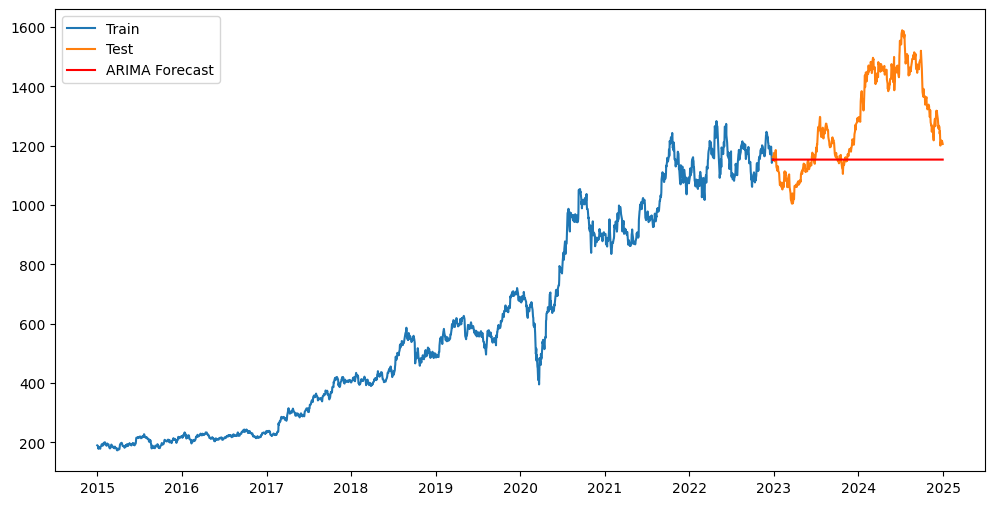

ARIMA RMSE: 200.56472277672052


In [8]:
data = df[["Close"]].dropna()

# Train/Test Split
train = data[:int(0.8*len(data))]
test = data[int(0.8*len(data)):]

# Fit ARIMA
model = ARIMA(train, order=(5,1,0))  # (p,d,q)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, forecast, label="ARIMA Forecast", color="red")
plt.legend()
plt.show()

# Error
rmse_arima = np.sqrt(mean_squared_error(test, forecast))
print("ARIMA RMSE:", rmse_arima)

20:00:21 - cmdstanpy - INFO - Chain [1] start processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing


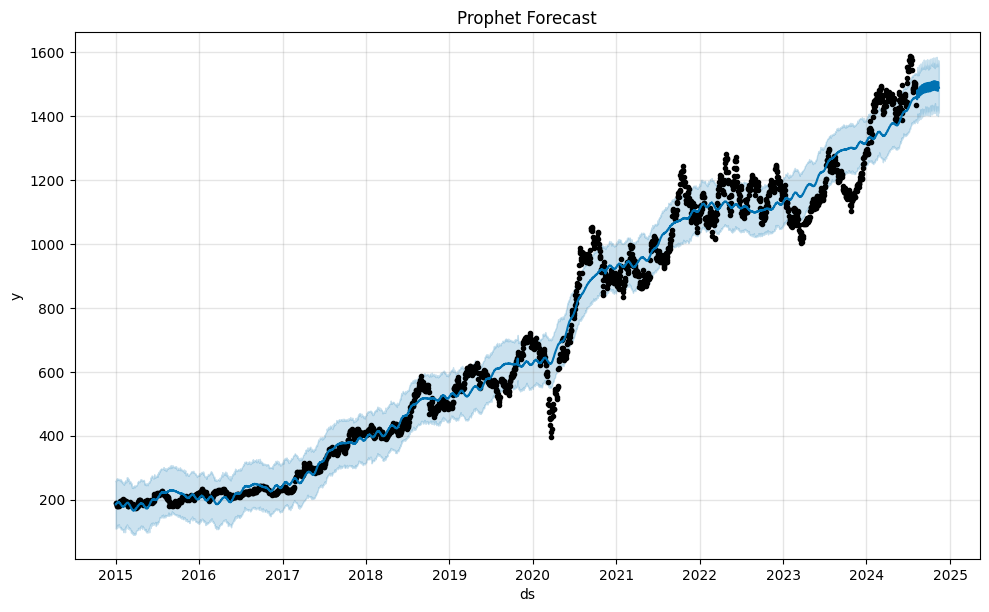

In [9]:
prophet_df = data.reset_index()[["Date", "Close"]]
prophet_df.columns = ["ds", "y"]

# Train
model = Prophet()
model.fit(prophet_df[:-100])

# Forecast next 100 days
future = model.make_future_dataframe(periods=100)
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

C:\Users\Neha Kumari\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 0.0098
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.9843e-04
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.6261e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 4.2762e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 4.1264e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.9797e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 3.9541e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 3.6744e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 3.5564e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 3.7106e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


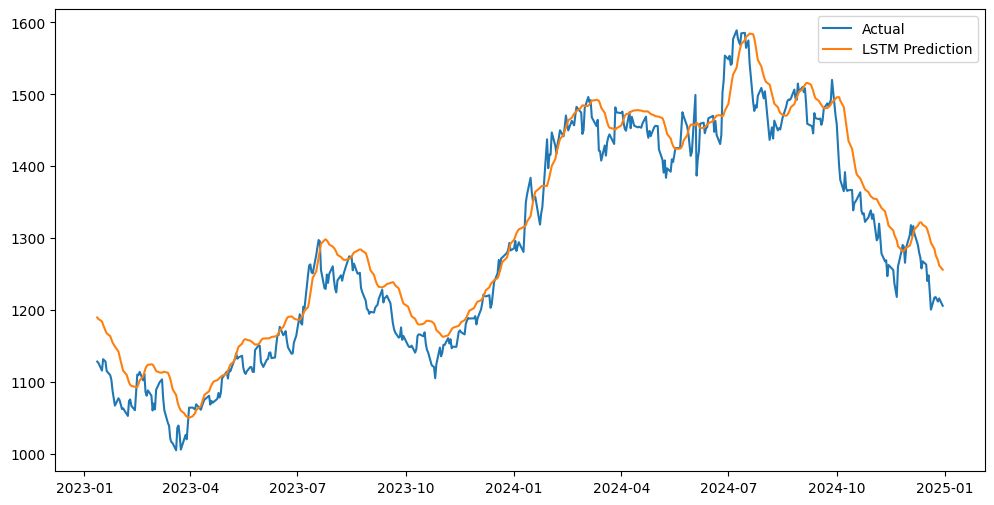

In [10]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# Create sequences
X, y = [], []
for i in range(60, len(scaled)):
    X.append(scaled[i-60:i])
    y.append(scaled[i, 0])
X, y = np.array(X), np.array(y)

# Train/Test Split
split = int(0.8*len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(data.index[-len(y_test):], pred, label="LSTM Prediction")
plt.legend()
plt.show()

In [11]:
rmse_lstm = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), pred))
print("LSTM RMSE:", rmse_lstm)

# Compare
print("ARIMA RMSE:", rmse_arima)
print("LSTM RMSE:", rmse_lstm)

LSTM RMSE: 38.58843426954624
ARIMA RMSE: 200.56472277672052
LSTM RMSE: 38.58843426954624


In [12]:
plt.savefig("closing_price.png")
plt.savefig("arima_forecast.png")
plt.savefig("lstm_prediction.png")

<Figure size 640x480 with 0 Axes>

In [13]:
# Example for LSTM
model.save("stock_lstm_model.h5")

# Save scaler too (important for predictions)
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']